In [1]:
import random
import time

import matplotlib.pyplot as plt
import scipy.integrate as integrate
import numpy as np
import pandas as pd
import networkx as nx

random.seed(time.time())

In [2]:
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [3]:
import ipywidgets as widgets

### Matrix input

In [4]:
states_number_input = widgets.BoundedIntText(value=0, min=0, max=100, step=1,
            layout=widgets.Layout(width="50px"))

randomize_input = widgets.Checkbox(value=False, description='Случайное заполнение', indent=False)

display(widgets.Label("Количество состояний в системе"))
display(states_number_input)
display(randomize_input)

Label(value='Количество состояний в системе')

BoundedIntText(value=0, layout=Layout(width='50px'))

Checkbox(value=False, description='Случайное заполнение', indent=False)

In [5]:
states_n = states_number_input.value

matrix_inputs = []
items = []

items += [widgets.Label("Состояния")]
items += [widgets.Label(f"$$\\text{{в }}S_{{{i+1}}}$$") for i in range(states_n)]

for i in range(states_n):
    items += [widgets.Label(f"$$\\text{{из }}S_{{{i+1}}}$$")]
    
    inputs = [
        widgets.BoundedFloatText(value= 0 if not randomize_input.value else round(random.random(), 2), min=0, max=10, step=0.01,
                                 layout=widgets.Layout(width="50px"))
        for _ in range(states_n)
    ]
    matrix_inputs += [inputs]
    items += inputs

display(widgets.Label("Таблица вероятностей перехода"))
display(widgets.GridBox(items, layout=widgets.Layout(grid_template_columns=f"repeat({states_n + 1}, 1fr)", overflow="auto")))

Label(value='Таблица вероятностей перехода')

GridBox(children=(Label(value='Состояния'), Label(value='$$\\text{в }S_{1}$$'), Label(value='$$\\text{в }S_{2}…

In [6]:
def get_matrix():
    return np.array([[float(matrix_inputs[i][j].value) for j in range(states_n)] 
             for i in range(states_n)])

### Graph

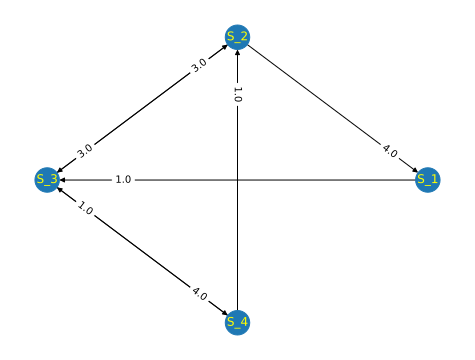

In [7]:
m = get_matrix()

G = nx.from_numpy_matrix(m, create_using=nx.DiGraph)
layout = nx.circular_layout(G)

nx.draw(G, layout, node_size=600)
nx.draw_networkx_labels(G, pos=layout, labels={
    i: f'S_{i+1}' for i in range(states_n)}, font_color='yellow', font_size=12)
nx.draw_networkx_edge_labels(G, pos=layout, 
                             edge_labels=nx.get_edge_attributes(G,'weight'), label_pos=0.2)
plt.show()

### Solution

In [8]:
t_max_input = widgets.BoundedFloatText(value=0, min=0, max=1000, step=1, description="Tmax")
t_n_input = widgets.BoundedIntText(value=0, min=0, max=10e4, step=1, description="N")

display(widgets.Label("Время моделирования"))
display(t_max_input)
display(t_n_input)

Label(value='Время моделирования')

BoundedFloatText(value=0.0, description='Tmax', max=1000.0, step=1.0)

BoundedIntText(value=0, description='N', max=100000)

In [9]:
eps = 1e-6
dt = 0.1
tn = t_n_input.value
tmax = t_max_input.value

m = get_matrix()

In [10]:
def find_stable(matrix):
    b = [0] * (len(matrix) - 1) + [1]
    
    matrix_to_solve = matrix.copy().transpose()
    matrix_to_solve -= np.diag(matrix.sum(axis=1))
    matrix_to_solve[-1] = np.ones(len(matrix_to_solve))

    return np.linalg.solve(matrix_to_solve, b)

In [11]:
def solve_ode(matrix, start_probs, tn, tmax, steady_states):
    matrix_to_solve = matrix.copy().transpose()
    matrix_to_solve -= np.diag(matrix.sum(axis=1))
    
    ts = np.linspace(0, tmax, tn)
    
    results = integrate.\
                    odeint(lambda w, _: matrix_to_solve @ w, 
                           start_probs, ts, atol=1.0e-8, rtol=1.0e-6).\
                    transpose()

    steady_ts = []

    for i in range(len(results)):
        row = results[i]
        flag = True
        for j in range(len(row) - 1, -1, -1):
            if abs(steady_states[i] - row[j]) > eps:
                steady_ts.append(ts[j])
                flag = False
                break
        if flag:
            steady_ts.append(0)
    
    return ts, results, steady_ts

def find_stable_time(matrix, start_probs, tn, tmax):
    ps = find_stable(matrix)
    return solve_ode(matrix, start_probs, tn, tmax, ps)

In [12]:
stable = find_stable(m).reshape((1, -1))

start_state_probs = np.ones(shape=(states_n,)) / states_n
start_state_probs = m[0]

ts, data, steady = find_stable_time(m, start_state_probs, tn, tmax)

print(sum(find_stable(m)))
df = pd.DataFrame.from_dict({
    'Стабильное состояние': find_stable(m),
    'Время': steady,
}, orient='index', columns=[f"$$S_{{{i+1}}}$$" for i in range(states_n)])
df.style.format("{:.3f}")

1.0


,$$S_{1}$$,$$S_{2}$$,$$S_{3}$$,$$S_{4}$$
Стабильное состояние,0.435,0.109,0.152,0.304
Время,7.520,6.499,5.840,7.357


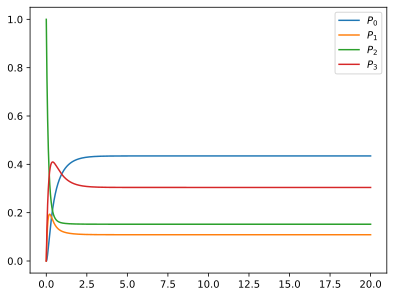

In [67]:
for i in range(len(data)):
    plt.plot(ts, data[i], label=f"$P_{{{i}}}$")
plt.legend()
plt.show()